In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import xarray as xr
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from tqdm.auto import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from hw3.direct_kernel_regression import direct_kernel_regression_estimate
from hw3.common import COL, estimate_loss


In [3]:
df = pd.read_csv('UJIndoorLoc/trainingData.csv')
test_df = pd.read_csv('UJIndoorLoc/validationData.csv')


In [4]:
df.PHONEID.value_counts()


14    4835
13    4516
7     1596
6     1383
23    1091
19     980
8      913
17     841
22     724
3      610
1      507
11     498
10     440
24     437
18     374
16     192
Name: PHONEID, dtype: int64

In [4]:
test_df


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7515.916799,4.864890e+06,1,1,0,0,0,0,1380872703
1,100,100,100,100,100,100,100,100,100,100,...,100,-7383.867221,4.864840e+06,4,2,0,0,0,13,1381155054
2,100,100,100,100,100,100,100,100,100,100,...,100,-7374.302080,4.864847e+06,4,2,0,0,0,13,1381155095
3,100,100,100,100,100,100,100,100,100,100,...,100,-7365.824883,4.864843e+06,4,2,0,0,0,13,1381155138
4,100,100,100,100,100,100,100,100,100,100,...,100,-7641.499303,4.864922e+06,2,0,0,0,0,2,1380877774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,100,100,100,100,100,100,100,100,100,100,...,100,-7317.344231,4.864796e+06,3,2,0,0,0,13,1381156711
1107,100,100,100,100,100,100,100,100,100,100,...,100,-7313.731120,4.864792e+06,3,2,0,0,0,13,1381156730
1108,100,100,100,100,100,100,100,100,100,100,...,100,-7637.535798,4.864903e+06,0,0,0,0,0,13,1381247781
1109,100,100,100,100,100,100,100,100,100,100,...,100,-7636.654005,4.864905e+06,0,0,0,0,0,13,1381247807


In [6]:
def estimate_loss(coor_true, coor_pred):
    coor_true_np, coor_pred_np = coor_true.values, coor_pred.values
    coor_error = np.sqrt(np.sum((coor_true_np[:, :2] - coor_pred_np[:, :2]) ** 2, axis=1))
    floor_error = (coor_true_np[:, 2] != coor_pred_np[:, 2]).astype(int) * 4
    building_error = (coor_true_np[:, 3] != coor_pred_np[:, 3]).astype(int) * 50
    return np.mean(coor_error) + np.mean(floor_error) + np.mean(building_error)

In [7]:
def gaussian_pdf(z):
    return np.exp(-z ** 2 / 2) / np.sqrt(2 * np.pi)


## Strategy 1: direct estimation


In [7]:
train_index, val_index = list(KFold(n_splits=3).split(df.sample(frac=0.1)))[0]


In [8]:
train_df, val_df = df.loc[train_index], df.loc[val_index]
train_X, train_lon, train_lat, train_floor, train_building = train_df.iloc[:, :520], train_df.iloc[:, 520], train_df.iloc[:, 521], train_df.iloc[:, 522], train_df.iloc[:, 523]
val_X, val_lon, val_lat, val_floor, val_building = val_df.iloc[:, :520], val_df.iloc[:, 520], val_df.iloc[:, 521], val_df.iloc[:, 522], val_df.iloc[:, 523]



In [9]:
train_X_na = train_X.replace(100, np.nan)
val_X_na = val_X.replace(100, np.nan)

In [10]:
weight_matrix = np.empty((len(train_X), len(val_X)))
CHUNK_SIZE = 100
for i in trange(int(np.ceil(len(val_X) / CHUNK_SIZE))):
    arr_end = min((i+1) * CHUNK_SIZE, len(val_X))
    weight_matrix[:, i*CHUNK_SIZE:arr_end] = np.sum(np.nan_to_num(gaussian_pdf(train_X_na.values[:, None, :] - val_X_na.values[None, i*CHUNK_SIZE:arr_end, :]), copy=False), axis=2)


  0%|          | 0/7 [00:00<?, ?it/s]

In [18]:
val_lon_pred = Series(data=(weight_matrix.T @ train_lon) / np.sum(weight_matrix, axis=0), index=val_df.index)
val_lon_pred.fillna(val_lon_pred.mean(), inplace=True)

val_lat_pred = Series(data=(weight_matrix.T @ train_lat) / np.sum(weight_matrix, axis=0), index=val_df.index)
val_lat_pred.fillna(val_lat_pred.mean(), inplace=True)

val_floor_pred = Series(data=(weight_matrix.T @ train_floor) / np.sum(weight_matrix, axis=0), index=val_df.index)
val_floor_pred.fillna(val_floor_pred.mean(), inplace=True)

val_building_pred = Series(data=(weight_matrix.T @ train_building) / np.sum(weight_matrix, axis=0), index=val_df.index)
val_building_pred.fillna(val_building_pred.mean(), inplace=True)


/tmp/ipykernel_22576/3244702075.py:1: RuntimeWarning: invalid value encountered in divide
  val_lon_pred = Series(data=(weight_matrix.T @ train_lon) / np.sum(weight_matrix, axis=0), index=val_df.index)
/tmp/ipykernel_22576/3244702075.py:4: RuntimeWarning: invalid value encountered in divide
  val_lat_pred = Series(data=(weight_matrix.T @ train_lat) / np.sum(weight_matrix, axis=0), index=val_df.index)
/tmp/ipykernel_22576/3244702075.py:7: RuntimeWarning: invalid value encountered in divide
  val_floor_pred = Series(data=(weight_matrix.T @ train_floor) / np.sum(weight_matrix, axis=0), index=val_df.index)
/tmp/ipykernel_22576/3244702075.py:10: RuntimeWarning: invalid value encountered in divide
  val_building_pred = Series(data=(weight_matrix.T @ train_building) / np.sum(weight_matrix, axis=0), index=val_df.index)


In [19]:
val_building_pred

0      1.000000
1      1.000000
2      1.033443
3      1.000000
4      1.557471
         ...   
660    1.000000
661    1.000000
662    1.044305
663    1.000000
664    1.084092
Length: 665, dtype: float64

In [29]:
val_pred = pd.concat([val_lon_pred, val_lat_pred, np.round(val_floor_pred).astype(int), np.round(val_building_pred).astype(int)], axis=1)
val = pd.concat([val_lon, val_lat, val_floor, val_building], axis=1)
estimate_loss(val, val_pred)

21.619493651688664

In [27]:
pd.concat([np.round(val_building_pred).astype(int), val_building], axis=1)


,0,BUILDINGID
0,1,1
1,1,1
2,1,1
3,1,1
4,2,0
...,...,...
660,1,1
661,1,1
662,1,1
663,1,1


In [101]:
prediction, _ = direct_kernel_regression_estimate(df.sample(frac=0.01), test_df[COL.WAPs])


  0%|          | 0/8 [00:00<?, ?it/s]

Best h is 1.778 and minimal cv loss is 33.398.


In [9]:
from hw3.common import estimate_loss
estimate_loss(test_df[[COL.LON, COL.LAT, COL.FLR, COL.BID]], prediction)


NameError: name 'prediction' is not defined

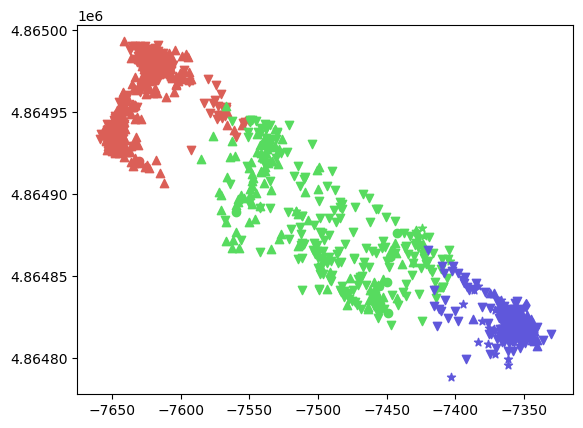

In [105]:
bcolor = sns.hls_palette(3)
fmarkers = ['o', '^', 'v', '*', 'd']

plt.figure()

for i in range(3):
    for j in range(5):
        mask = (prediction[COL.FLR] == j) & (prediction[COL.BID] == i)
        sub_df = prediction.loc[mask]
        plt.scatter(sub_df[COL.LON], sub_df[COL.LAT], color=bcolor[i], marker=fmarkers[j])

plt.show()


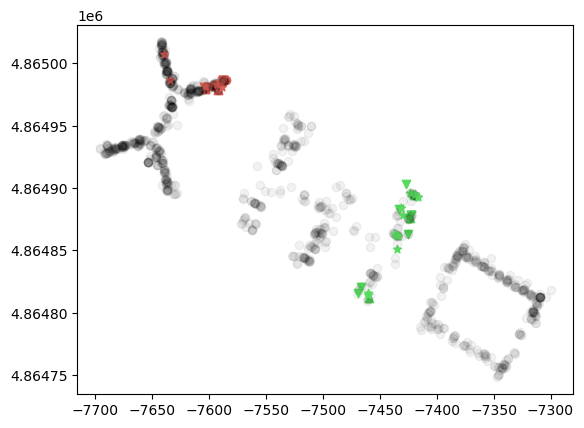

In [133]:
bcolor = sns.hls_palette(3)
fmarkers = ['o', '^', 'v', '*', 'd']

plt.figure()

for i in range(3):
    for j in range(5):
        selection = (test_df[COL.FLR] == j) & (test_df[COL.BID] == i)
        mask = prediction[selection][COL.BID] != i

        mismatch = mask.index[np.where(mask)[0]]
        match = mask.index[np.where(~mask)[0]]
        plt.scatter(test_df.iloc[mismatch][COL.LON], test_df.iloc[mismatch][COL.LAT], color=bcolor[i], marker=fmarkers[j])
        plt.scatter(test_df.iloc[match][COL.LON], test_df.iloc[match][COL.LAT], color='k', alpha=0.05)

plt.show()

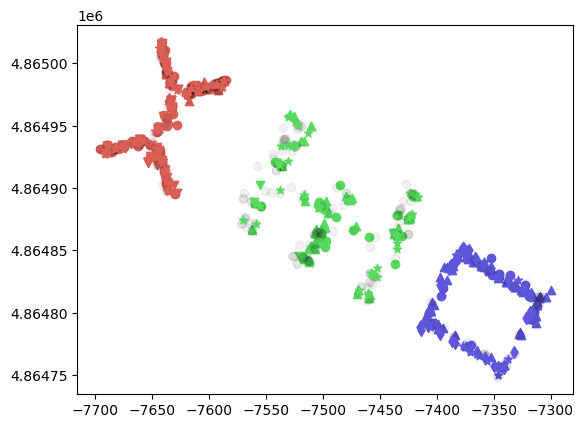

In [134]:
bcolor = sns.hls_palette(3)
fmarkers = ['o', '^', 'v', '*', 'd']

plt.figure()

for i in range(3):
    for j in range(5):
        selection = (test_df[COL.FLR] == j) & (test_df[COL.BID] == i)
        mask = prediction[selection][COL.FLR] != j

        mismatch = mask.index[np.where(mask)[0]]
        match = mask.index[np.where(~mask)[0]]
        plt.scatter(test_df.iloc[mismatch][COL.LON], test_df.iloc[mismatch][COL.LAT], color=bcolor[i], marker=fmarkers[j])
        plt.scatter(test_df.iloc[match][COL.LON], test_df.iloc[match][COL.LAT], color='k', alpha=0.05)

plt.show()


## Now we move to the router-based method


In [10]:
# examine if routers can move through different buildings
for _ in range(1000):
    row1 = df.sample(1)
    row2 = df.sample(1)
    if row1[COL.BID].item() != row2[COL.BID].item():
        mask = (row1[COL.WAPs] != 100).values & (row2[COL.WAPs] != 100).values
        common_wap, = np.where(mask.squeeze())
        if len(common_wap) > 0:
            print(row1.iloc[:, common_wap])
            print(row2.iloc[:, common_wap])
            print()

# hmm looks like we got some inter-building samples!


       WAP248
11657     -78
       WAP248
13627     -84

      WAP248
7417     -83
       WAP248
10413     -75

      WAP113  WAP114  WAP141  WAP146  WAP478
5170     -62     -66     -90     -82     -73
       WAP113  WAP114  WAP141  WAP146  WAP478
14510     -76     -85     -85     -85     -58

       WAP166
17691     -86
      WAP166
1531     -96

       WAP011  WAP012  WAP145  WAP248
14671     -79     -76     -85     -85
      WAP011  WAP012  WAP145  WAP248
6199     -88     -88     -83     -83

      WAP248
7703     -84
      WAP248
6127     -79

      WAP478
5972     -87
      WAP478
9291     -84

       WAP248
16235     -63
       WAP248
11967     -84

      WAP248
2189     -82
      WAP248
8331     -91

       WAP184  WAP185
17635     -88     -86
      WAP184  WAP185
8344     -92     -88

      WAP185
4651     -67
       WAP185
16422     -88

       WAP503
18811     -91
      WAP503
4146     -92

      WAP185
8167     -95
       WAP185
19864     -90

       WAP248
11972     -81
   

In [11]:
import torch

In [12]:
sub_df = df.sample(frac=0.01)[COL.WAPs + [COL.LON, COL.LAT, COL.FLR]]
user_coor_np = sub_df[[COL.LON, COL.LAT, COL.FLR]].values
user_coor = torch.from_numpy(user_coor_np)


In [13]:
user_coor.shape


torch.Size([199, 3])

In [71]:
# wap_coor = user_coor.mean(dim=0) + torch.randn((520, 3))
weight = np.power(sub_df[COL.WAPs].replace(100, np.nan) / 104.0 + 1.0, 0.3).fillna(0).values + 1e-12
wap_coor_np = (weight.T @ user_coor_np) / weight.sum(axis=0)[:, None]
wap_coor = torch.from_numpy(wap_coor_np)


In [72]:
wap_coor


tensor([[-7.4674e+03,  4.8649e+06,  1.6432e+00],
        [-7.4674e+03,  4.8649e+06,  1.6432e+00],
        [-7.4674e+03,  4.8649e+06,  1.6432e+00],
        ...,
        [-7.4674e+03,  4.8649e+06,  1.6432e+00],
        [-7.4674e+03,  4.8649e+06,  1.6432e+00],
        [-7.4674e+03,  4.8649e+06,  1.6432e+00]], dtype=torch.float64)

In [16]:
query_row_np, query_column_np = np.where(sub_df[COL.WAPs] != 100)
query_row = torch.from_numpy(query_row_np)
query_column = torch.from_numpy(query_column_np)

In [124]:
RSSIs = torch.tensor([sub_df.iloc[row, column] for row, column in zip(query_row_np, query_column_np)]) / 104.0 * (-1.0)
RSSIs = 1 / np.sqrt(1-RSSIs[:, None])
RSSIs.requires_grad_(False)
RSSIs.shape

torch.Size([3438, 1])

<Axes: ylabel='Count'>

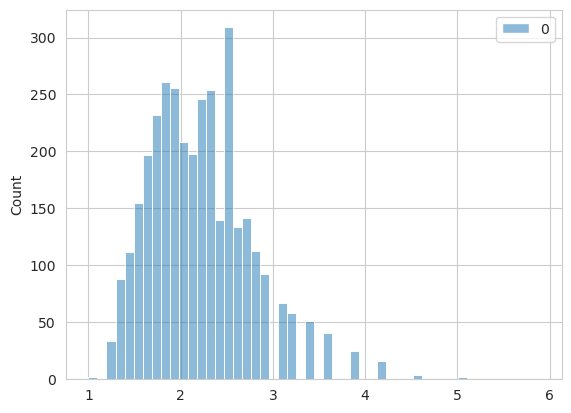

In [122]:
import seaborn as sns
sns.histplot(RSSIs.numpy())

In [19]:
user_coor_expanded = torch.index_select(user_coor, 0, query_row)


In [20]:
def distance_calculation(user_coor_expanded, wap_coor, query_column, floor_weight):
    wap_coor_expanded = torch.index_select(wap_coor, 0, query_column)
    adjust_weight = torch.concat([torch.tensor([1, 1]), floor_weight])
    return torch.sqrt((((user_coor_expanded - wap_coor_expanded) * adjust_weight[None, :]) ** 2).sum(dim=1))[:, None]


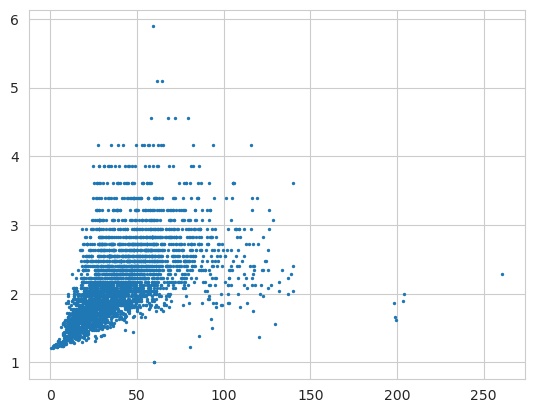

In [125]:
plt.scatter(distance_calculation(user_coor_expanded, wap_coor, query_column, torch.tensor([10])).detach().numpy(), RSSIs.numpy(), s=2)


In [126]:
import torch.nn as nn

class Polynomial(nn.Module):
    def __init__(self):
        super().__init__()

        self.a = nn.Parameter(torch.randn(1))
        self.b = nn.Parameter(torch.randn(1))
        self.c = nn.Parameter(torch.randn(1))
        self.d = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return self.a + self.b * x + self.c * x ** 2 + self.d * x ** 3


In [127]:
wap_coor.requires_grad_(True)
wap_coor.requires_grad


True

In [128]:
floor_weight = torch.tensor([4.0], requires_grad=True)


In [129]:
from itertools import chain
from torch.optim import Adam

polynomial = Polynomial()
parameters = chain([wap_coor, floor_weight], polynomial.parameters())
optimizer = Adam(parameters, lr=1e-2)



In [146]:
for _ in range(1000):
    optimizer.zero_grad()
    RSSI_pred = polynomial(distance_calculation(user_coor_expanded, wap_coor, query_column, floor_weight)/50.0)
    loss = torch.mean((RSSI_pred - RSSIs)**2)
    # print(wap_coor[0])
    print(loss)
    loss.backward()
    optimizer.step()



tensor(0.1352, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1352, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(0.1352, dtype=tor

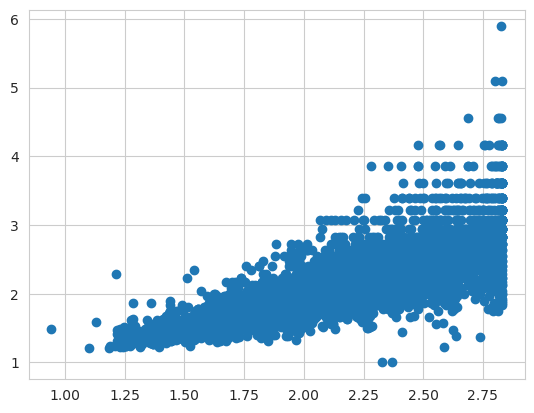

In [147]:
plt.scatter(RSSI_pred.detach().numpy(), RSSIs.detach().numpy())


In [148]:
list(polynomial.parameters())

[Parameter containing:
 tensor([0.4362], requires_grad=True),
 Parameter containing:
 tensor([2.5476], requires_grad=True),
 Parameter containing:
 tensor([-0.8123], requires_grad=True),
 Parameter containing:
 tensor([0.0675], requires_grad=True)]

In [149]:
floor_weight

tensor([27.9837], requires_grad=True)

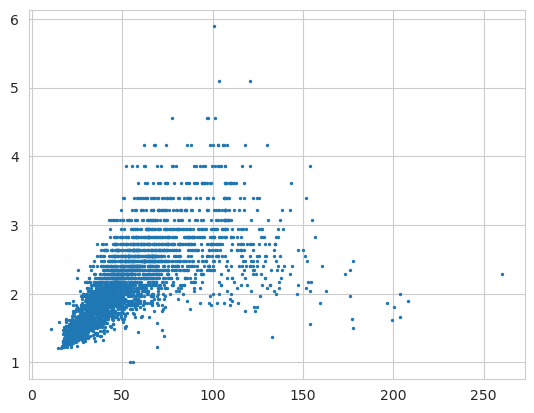

In [150]:
plt.scatter(distance_calculation(user_coor_expanded, wap_coor, query_column, floor_weight).detach().numpy(), RSSIs.numpy(), s=2)


In [155]:
# pick a victim from test set
test_sub_df = test_df.iloc[1, :]
test_sub_df


WAP001              1.000000e+02
WAP002              1.000000e+02
WAP003              1.000000e+02
WAP004              1.000000e+02
WAP005              1.000000e+02
                        ...     
SPACEID             0.000000e+00
RELATIVEPOSITION    0.000000e+00
USERID              0.000000e+00
PHONEID             1.300000e+01
TIMESTAMP           1.381155e+09
Name: 1, Length: 529, dtype: float64

In [163]:
test_query_column_np, = np.where(test_sub_df[COL.WAPs] != 100)
test_query_column = torch.from_numpy(test_query_column_np)
test_RSSIs = (1 / np.sqrt(1+torch.from_numpy(test_sub_df.iloc[test_query_column].values) / 104.0))[None, :]
test_query_column, test_RSSIs


(tensor([ 10,  11,  64,  83,  84, 113, 138, 143, 144, 247, 276, 341]),
 tensor([[2.4734, 2.4734, 3.2249, 2.5495, 2.4734, 3.3993, 2.8284, 1.4875, 1.4720,
          3.0748, 3.3993, 2.6331]], dtype=torch.float64))

In [165]:
test_user_coord_tensor = torch.index_select(wap_coor, 0, test_query_column).mean(dim=0).clone().detach().requires_grad_(True).to(float)
test_user_coord_tensor


tensor([-7.3910e+03,  4.8648e+06,  2.8593e+00], dtype=torch.float64,
       requires_grad=True)

In [166]:
test_user_coord_tensor.detach().numpy() - test_sub_df[[COL.LON, COL.LAT, COL.FLR]].values


array([ -7.14136572, -16.49115406,  -1.14068434])

In [174]:
test_optimizer = Adam([test_user_coord_tensor])
for _ in range(100):
    test_optimizer.zero_grad()
    test_RSSI_pred = polynomial(distance_calculation(test_user_coord_tensor[None, :], wap_coor, query_column, floor_weight)/50.0)
    test_loss = torch.mean((test_RSSI_pred - test_RSSIs)**2)
    # print(wap_coor[0])
    print(test_loss)
    test_loss.backward()
    test_optimizer.step()


tensor(1.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0254, dtype=torch.float64, grad_fn=<MeanBackward0>)
tensor(1.0254, dtype=tor

In [175]:
test_user_coord_tensor.detach().numpy() - test_sub_df[[COL.LON, COL.LAT, COL.FLR]].values


array([ -7.53976742, -16.09787173,  -0.94022102])

### Test lib function!


In [7]:
from hw3.wap_based import wap_based_estimate


In [61]:
test_coor = wap_based_estimate(df, test_df[COL.WAPs], n_epoch=2, n_test_itr=50)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/1111 [00:00<?, ?it/s]

In [65]:
tt = test_coor.rename(columns={0:COL.LON,1: COL.LAT,2: COL.FLR}).copy()
tt[COL.BID] = test_df[COL.BID]

(26.82490912223289,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 2 Axes>,
 <Figure size 640x480 with 1 Axes>,
 <Figure size 640x480 with 1 Axes>)

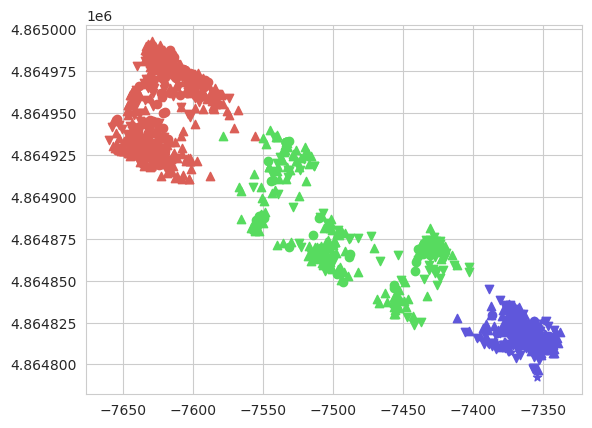

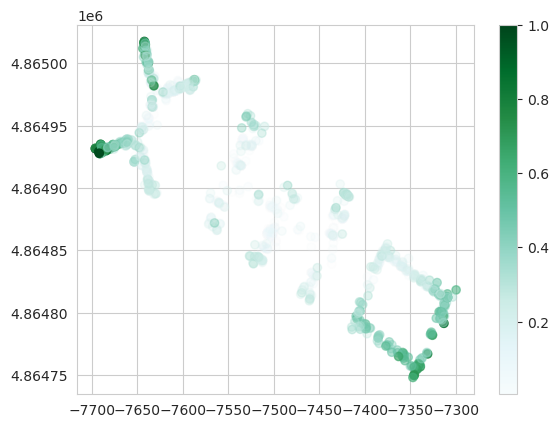

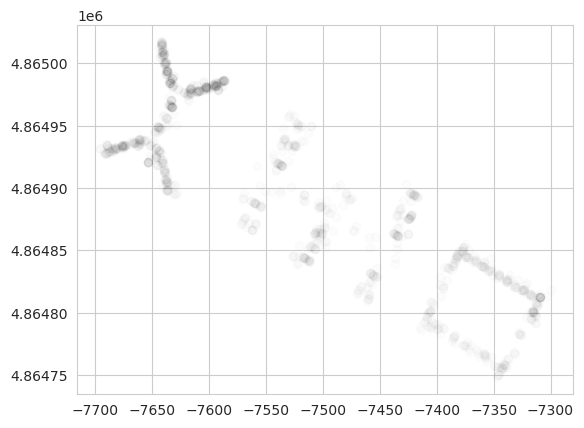

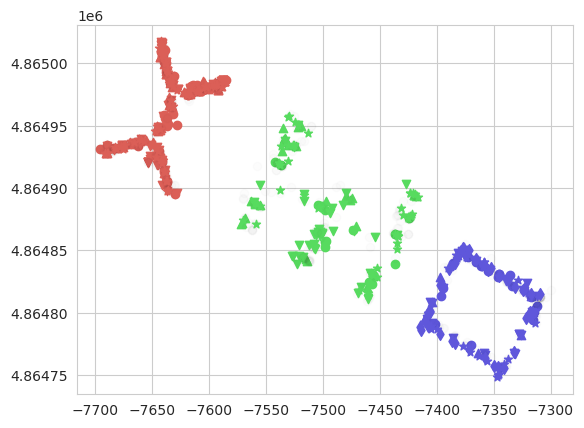

In [70]:
estimate_loss(test_df[[COL.LON, COL.LAT, COL.FLR, COL.BID]], tt)

In [68]:
tt.FLOOR = tt.FLOOR.astype(int)

In [69]:
tt

,LONGITUDE,LATITUDE,FLOOR,BUILDINGID
0,-7501.878801,4.864881e+06,1,1
1,-7375.484610,4.864824e+06,1,2
2,-7366.828570,4.864831e+06,3,2
3,-7364.662722,4.864827e+06,3,2
4,-7647.997135,4.864928e+06,1,0
...,...,...,...,...
1106,-7354.802653,4.864822e+06,2,2
1107,-7340.828204,4.864812e+06,2,2
1108,-7651.533250,4.864927e+06,1,0
1109,-7644.832618,4.864924e+06,1,0
